In [43]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import statsmodels
import statsmodels.api as sm
from statsmodels.graphics.regressionplots import abline_plot

In [44]:
df = pd.read_csv('data_all.csv', sep=';', usecols=['name', 'surname', 'sport', 'start', 'end', 'top', 'reps', 'impr'])
df['impr'] = df['impr'].map(lambda x: float(int(x[:-1])) / 100)
df['reps'] = df['reps'].map(lambda x: int(x[:-1]))
df['sport'] = df['sport'].replace({'rozhodčí basket': 'basketbal', 'hokej golman': 'hokej', 'fotbal golman': 'fotbal'})
# df = df[(df['impr'] < 10) & (df['reps'] < 300) & (df['impr'] > 1.1)]
df.head()

,name,surname,sport,start,end,top,reps,impr
0,Lucie,Halakucová,softball,0.90,1.54,1.95,30,3.20
1,Eliska,Thompsonova,softball,0.68,1.99,2.60,91,4.54
2,Matyáš,Vágner,fotbal,0.98,2.14,2.43,45,3.16
3,Charlotte,Velichova,basketbal,1.14,1.61,1.96,18,3.37
4,Simon,Hrubec,hokej,0.52,2.16,2.58,88,5.72


In [45]:
df['sport'].value_counts()

hokej                22
basketbal            12
softball             10
fotbal                9
tenis                 3
stolní tenis          1
strelba               1
violoncello           1
pozemní hokej         1
MMA                   1
baseball              1
sjezdové lyžování     1
florbal               1
aikido                1
Name: sport, dtype: int64

### Distribuce zlepšení, opakování a celkový graf

Z datasetu jsem odebral "odlehlé hodnoty" - vzorky s moc odlišnými hodnotami. Ony
pak totiž kurví statistiku. V našem případě to bylo zlepšení přes 1000 %, počet opakování
přes 300 nebo zlepšení pod 110 %

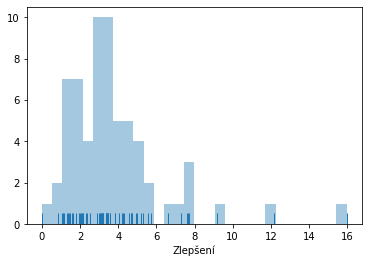

In [46]:
ax = sns.distplot(df['impr'], bins=30, kde=False, rug=True, label='Distribuce zlepšení',
             axlabel='Zlepšení')
ax.get_figure().savefig('zlepseni.png')


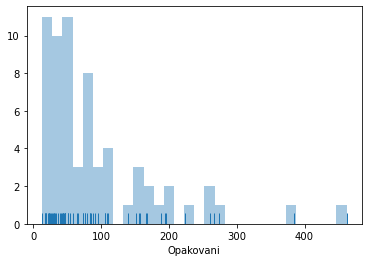

In [47]:
ax = sns.distplot(df['reps'], bins=30, kde=False, rug=True, label='Distribuce opakovani',
             axlabel='Opakovani')
ax.get_figure().savefig('opak.png')


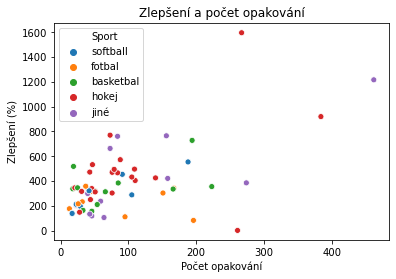

In [48]:
wcs = df['sport'].value_counts()
sports_filtered = df['sport'].map(lambda x:
                                  x if wcs.loc[x] >= 4
                                  else 'jiné')
df['Sport'] = sports_filtered

ax = sns.scatterplot(x=df['reps'], y=df['impr'] * 100, hue=df['Sport'])
ax.set_title('Zlepšení a počet opakování')
ax.set(xlabel='Počet opakování', ylabel='Zlepšení (%)')
ax.get_figure().savefig('zlepseni_x_reps.png')
ax

### Zlepšili se ti, kdo to dělali víckrát?

Podle grafu se dá říct, že s počtem opakování zlepšení tak nějak roste, ale
není to úplně jasně vidět. Pearsonův korelační koeficient vychází 0,42
s p-hodnotou 0.00068, což znamená, že to, že by data byla ve skutečnosti nekorelovaná
je extrémně nepravděpodobné.

Vzhledem k tomu, že ani jedna distribuce (opakování ani zlepšení) není
normální (= gausovka), je lepší použít Spearmanův korelační koeficient,
který detekuje jakoukoliv monotónní závislost. Pearson je pouze pro lineární,
tudíž kdyby ta data tvořila třeba parabolu, vyjde Pearson nízký, byť
ta data jednoznačně závislá budou.

Spearman vychází 0,45 s p-hodnotou, která také dost nízká, můžeme
si tedy být docelajistí, že v datech je nějaká rostoucí závislost,
byť ne moc silná.

Pokud volíme hladinu spolehlivosti 5 % a tanovíme-li:
------------------
    H0 ~ Data jsou nekorelovaná.
    HA ~ Počet opakování testu koreluje se zlepšením (=počet opakování
    testu nějak určuje míru zlepšení).

Můžeme pak nulovou hypotéhu zamitnout ve prospěch HA. To lze, jelikož
p-hodnota testu je 0.000165, což je nižší než zvolená hladina
spolehlivosti.

In [49]:
scipy.stats.pearsonr(x=df['reps'], y=df['impr'])

(0.5753822233804076, 5.34046767532377e-07)

In [50]:
scipy.stats.spearmanr(a=df['reps'], b=df['impr'])

SpearmanrResult(correlation=0.45056338507677773, pvalue=0.00016573341348543124)

Zajímavé je porovnání jednotlivých sportů - u hokejek je středně silná korelace
průkazná na hladině spolehlivosti 95 %, u softballistů je to totál sicher
a u basketbalistů je to naprosto neprůkazný - moc vysoké p-hodnoty, hladina
spolehlivosti by byla nějakých 52 % u Spearmana, což je naprosto nepoužitelné.

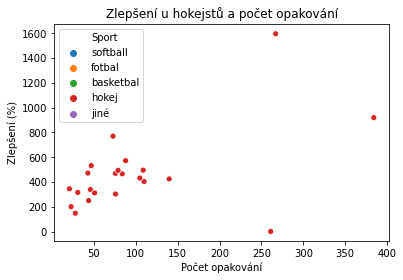

(0.5227353094933954, 0.012558935135123423)
SpearmanrResult(correlation=0.4518497779730495, pvalue=0.03476266137841134)


In [51]:
s = 'hokej'
df_sport = df[df['sport'] == s]
ax = sns.scatterplot(x=df_sport['reps'], y=df_sport['impr'] * 100, hue=df['Sport'])
ax.set_title('Zlepšení u hokejstů a počet opakování')
ax.set(xlabel='Počet opakování', ylabel='Zlepšení (%)')
ax.get_figure().savefig(f'zlepseni_x_reps_{s}.png')
plt.show(ax)
print(scipy.stats.pearsonr(x=df_sport['reps'], y=df_sport['impr']))
print(scipy.stats.spearmanr(a=df_sport['reps'], b=df_sport['impr']))

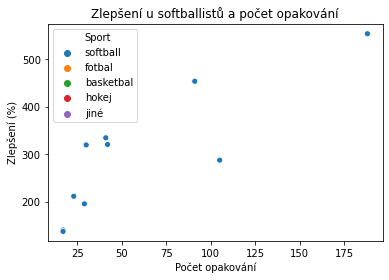

(0.8413838495025128, 0.0022762281116641614)
SpearmanrResult(correlation=0.8510677611520904, pvalue=0.0017911300301950454)


In [52]:
s = 'softball'
df_sport = df[df['sport'] == s]
ax = sns.scatterplot(x=df_sport['reps'], y=df_sport['impr']* 100, hue=df['Sport'])
ax.set_title('Zlepšení u softballistů a počet opakování')
ax.set(xlabel='Počet opakování', ylabel='Zlepšení (%)')
ax.get_figure().savefig(f'zlepseni_x_reps_{s}.png')
plt.show(ax)
print(scipy.stats.pearsonr(x=df_sport['reps'], y=df_sport['impr']))
print(scipy.stats.spearmanr(a=df_sport['reps'], b=df_sport['impr']))

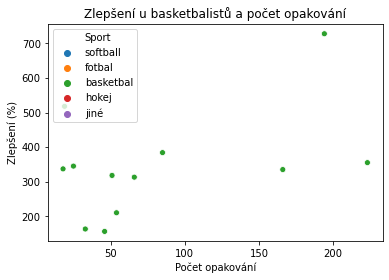

(0.43994374876881254, 0.1523750488651165)
SpearmanrResult(correlation=0.22377622377622378, pvalue=0.48445166145539886)


In [53]:
s = 'basketbal'
df_sport = df[(df['sport'] == s) | (df['sport'] == 'rozhodčí basket')]
ax = sns.scatterplot(x=df_sport['reps'], y=df_sport['impr']* 100, hue=df['Sport'])
ax.set_title('Zlepšení u basketbalistů a počet opakování')
ax.set(xlabel='Počet opakování', ylabel='Zlepšení (%)')
ax.legend(loc='upper left')
ax.get_figure().savefig(f'zlepseni_x_reps_{s}.png')
plt.show(ax)
print(scipy.stats.pearsonr(x=df_sport['reps'], y=df_sport['impr']))
print(scipy.stats.spearmanr(a=df_sport['reps'], b=df_sport['impr']))

Průměrné zlepšení u sportu
-------------------------------------
Test hypotézy:

    H0: Dva sporty mají stejný průměr

    HA: Průměr dvou sportů je jiný

hokej, basketbal pvalue=0.2325 > 0,05 => NEZAMÍTÁME

hokej, softball: pvalue=0.1164 > 0,05 => NEZAMÍTÁME

basketbal, softball pvalue=0.4254  > 0,05 => NEZAMÍTÁME

In [54]:
df.groupby('Sport').mean()[['impr']]


,impr
Sport,
basketbal,3.468333
fotbal,2.373333
hokej,4.665909
jiné,4.425000
softball,2.959000


In [55]:
sporty = ['hokej', 'basketbal', 'softball']
from itertools import combinations
from scipy.stats import ttest_ind
for c in combinations(sporty, 2):
    a = df[df['sport'] == c[0]]['impr']
    b = df[df['sport'] == c[1]]['impr']
    p = ttest_ind(a, b)
    print(f'{c}: {p}')

('hokej', 'basketbal'): Ttest_indResult(statistic=1.216837738920715, pvalue=0.23256473542257228)
('hokej', 'softball'): Ttest_indResult(statistic=1.6164367910912705, pvalue=0.11646878831366407)
('basketbal', 'softball'): Ttest_indResult(statistic=0.8135901539390515, pvalue=0.42546039863277596)
